In [1]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn        
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time
from matplotlib.widgets import Slider


# Ecuación de Transporte
Sea $(x,t) \in \Omega = [-5,5]\times [0,3]$. Determinar $u(t,x)$ que satisfaga: 

1. $$u_t + c\, u_x  = 0 \hspace{0.8cm}  \text{en el interior de } \Omega,$$

2. $$u(x, 0) = f(x)  \hspace{0.8cm}  \text{en } [0,3] ,$$

<!--  3. $$ \dfrac{\partial u}{\partial t} = g(t) \hspace{0.8cm}  \text{en } [0,1],$$ -->

donde $c$ es una constante positiva.

## Problema. 

Resuelva la ecuacion de transporte para $c=3$ y  $f(x) = \dfrac{1}{1 + x^2}$

## Funciones Auxiliares

In [2]:
#Graficos 3D
def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y

    fig = plt.figure(figsize = (14,6))

    ax1 = fig.add_subplot(1,2,1)
    contour = ax1.contourf(X, T, F_xt, 20, cmap="rainbow")
    fig.colorbar(contour, ax=ax1)
    ax1.set_title('Contorno u(x,t)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax2.plot_surface(X, T, F_xt, cmap="rainbow")
    fig.colorbar(surf, ax=ax2)
    ax2.set_title('Superficie 3D u(x,t)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('u')

    plt.show()

## Generación del dominio

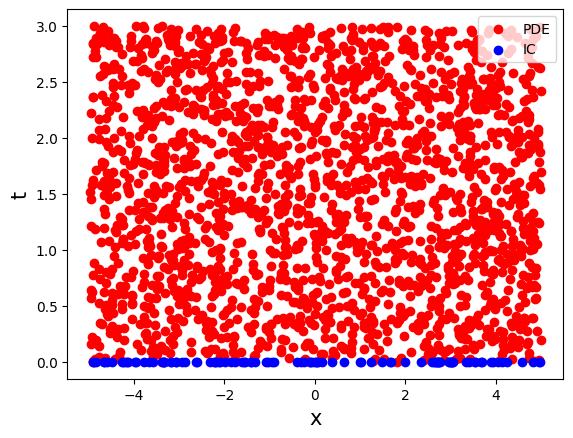

In [3]:
x_min = -5.0
x_max = 5.0
t_min = 0.0
t_max = 3.0

# Puntos colocacion PDE
N_f = 2000
x_data = x_min + (x_max - x_min) * torch.rand(N_f) 
t_data = t_min + (t_max - t_min) * torch.rand(N_f)

x_data = x_data.float().reshape(-1,1)
t_data = t_data.float().reshape(-1,1)

x_data.requires_grad = True
t_data.requires_grad = True

# Boundary condition
N_u = 100

x_init = x_min + (x_max - x_min) * torch.rand(N_u)
t_init = 0.0 * torch.ones(N_u)

x_init = x_init.float().reshape(-1,1)
t_init = t_init.float().reshape(-1,1)

# Puntos de Entrenamiento
plt.scatter(x_data.detach().numpy(), t_data.detach().numpy() , color = 'r', label = 'PDE')
plt.scatter(x_init.detach().numpy(), t_init.detach().numpy() , color = 'b', label = 'IC')
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.legend()
plt.show()

In [7]:
class Trans_Net(nn.Module):
    def __init__(self):
        super(Trans_Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        ) 

        #self.c = nn.Parameter(torch.tensor(2.0))

        self.c = torch.tensor(3.0)

        self.loss_function = nn.MSELoss(reduction ='mean')

        self.iter = 0
        
        self.loss_hist = {'loss':[], 'pde_loss':[], 'bc_loss':[]}

    def forward(self, x, t):
        X = torch.cat([x, t], 1)
        return self.layers(X)
    
    def loss_PDE(self, x, t):
        u = self.forward(x,t)
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return self.loss_function(u_t + self.c * u_x, torch.zeros_like(u))
    
    def loss_BC(self, x, t):
        return self.loss_function(self.forward(x,t), 1/(1 + x**2))
    
    def loss(self, x_c, t_c, x_i, t_i):
        loss_pde = self.loss_PDE(x_c, t_c)
        loss_bc = self.loss_BC(x_i, t_i)
        loss = loss_pde + loss_bc
        return loss, loss_pde, loss_bc

    def train(self, x_c, t_c, x_i, t_i, epochs = 100, lr = 0.001, lbfgs = False):

        # Adam Optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr)

        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss, loss_pde, loss_bc = self.loss(x_c, t_c, x_i, t_i)
            loss.backward()
            optimizer.step()
            
            self.loss_hist['loss'].append(loss.item())
            self.loss_hist['pde_loss'].append(loss_pde.item())
            self.loss_hist['bc_loss'].append(loss_bc.item())

            if epoch % 50 == 0:
                    print(f"Epoch {epoch}: Loss {loss.item()}")

        if lbfgs:

            print("Starting optimization with L-BFGS")

            optimizer = torch.optim.LBFGS(self.parameters(), lr=0.1,
                    max_iter = 50000,
                    max_eval = None,
                    tolerance_grad = 1e-11,
                    tolerance_change = 1e-11,
                    history_size = 50,
                    line_search_fn = 'strong_wolfe')

            # L-BFGS Optimizer
            def closure():
                optimizer.zero_grad()
                loss, loss_pde, loss_bc = self.loss(x_c, t_c, x_i, t_i)
                loss.backward()
                self.loss_hist['loss'].append(loss.item())
                self.loss_hist['pde_loss'].append(loss_pde.item())
                self.loss_hist['bc_loss'].append(loss_bc.item())

                self.iter +=1

                if self.iter % 50 == 0:
                    print(f"Epoch {self.iter}: Loss {loss.item()}")


                return loss
            

            # Optimización
            start_time = time.time()
            optimizer.step(closure)  # Directamente usando self.closure
            elapsed = time.time() - start_time
            print('Finish: Training time L-BFGS: %.2f' % elapsed)
        
    

In [8]:
Net = Trans_Net()

In [9]:
Net.train(x_data, t_data, x_init, t_init, epochs=1000, lbfgs=True )

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 0.3221569359302521
Epoch 50: Loss 0.039098262786865234
Epoch 100: Loss 0.027122147381305695
Epoch 150: Loss 0.0184651967138052
Epoch 200: Loss 0.013704594224691391
Epoch 250: Loss 0.008947968482971191
Epoch 300: Loss 0.004940560087561607
Epoch 350: Loss 0.002367277629673481
Epoch 400: Loss 0.0010685244342312217
Epoch 450: Loss 0.000523278140462935
Epoch 500: Loss 0.00030170707032084465
Epoch 550: Loss 0.00019941355276387185
Epoch 600: Loss 0.00014190361252985895
Epoch 650: Loss 0.00010436057345941663
Epoch 700: Loss 7.839142199372873e-05
Epoch 750: Loss 6.019365173415281e-05
Epoch 800: Loss 4.728702697320841e-05
Epoch 850: Loss 3.7943496863590553e-05
Epoch 900: Loss 3.1020710594020784e-05
Epoch 950: Loss 2.5782830562093295e-05
Starting optimization with L-BFGS
Epoch 50: Loss 9.173979378829245e-06
Epoch 100: Loss 4.938806341669988e-06
Epoch 150: Loss 3.2505965918971924e-06
Epoch 200: Loss 2.0349116311990656e-06
Epoch 250: Loss 1.5165850300036254e-06
Epoch 300: Loss 1.04671

## Resultados

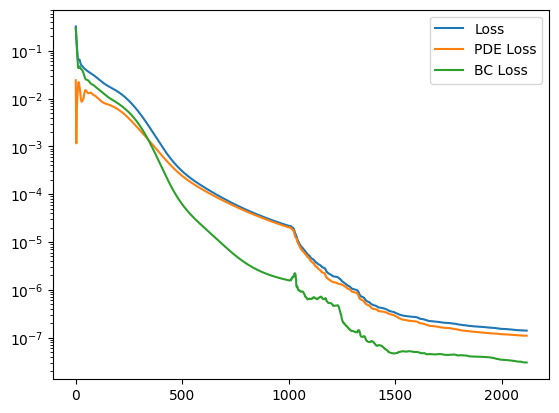

In [10]:
# Gráfica Loss
plt.plot(Net.loss_hist['loss'], label = 'Loss')
plt.plot(Net.loss_hist['pde_loss'], label = 'PDE Loss')
plt.plot(Net.loss_hist['bc_loss'], label = 'BC Loss')
plt.yscale('log')
plt.legend()
plt.show()

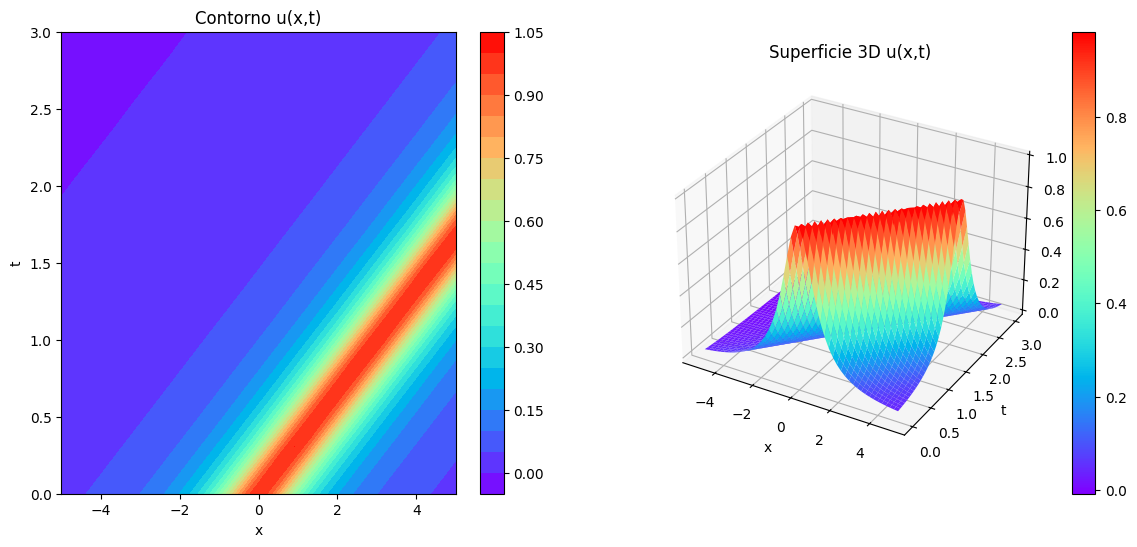

In [11]:
# plot prediccion
N_t = 50
x_test, t_test = np.meshgrid(np.linspace(x_min, x_max, N_t), np.linspace(t_min, t_max, N_t))
x_test_ = torch.tensor(x_test.flatten()).clone().detach().view(-1, 1).float()
t_test_ = torch.tensor(t_test.flatten()).clone().detach().view(-1, 1).float()


u_pred = Net(x_test_, t_test_).detach().numpy().reshape(N_t, N_t)
u_pred_ = Net(x_test_, t_test_).detach().numpy()

plot3D_Matrix(x_test,t_test,u_pred)



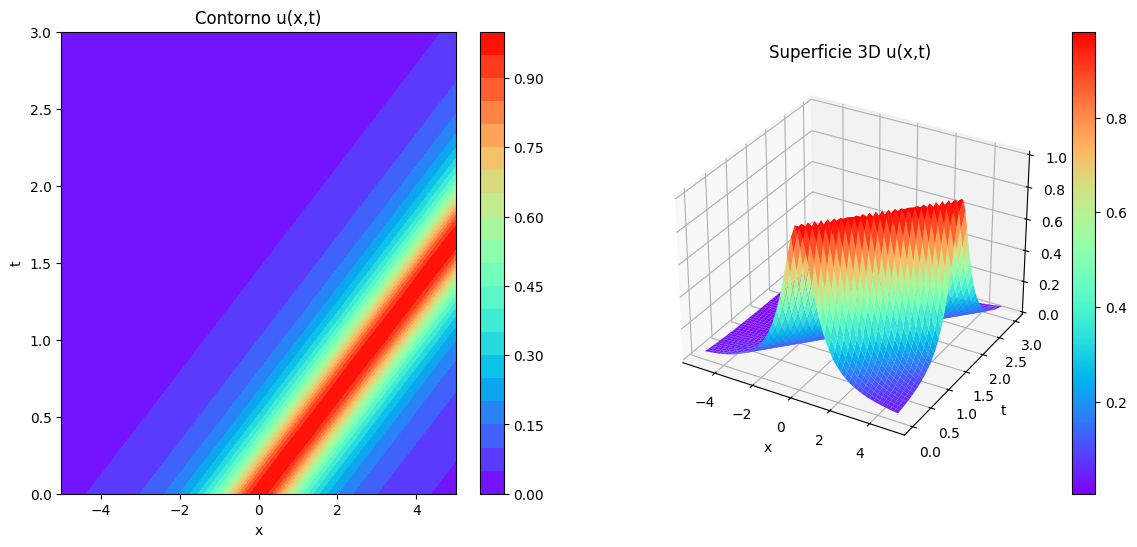

In [12]:
# Plot Solución Real
u_real = 1/(1 + ( x_test - 3.0 * t_test)**2)
plot3D_Matrix(x_test, t_test, u_real)

# Guardar solución real
df = pd.DataFrame(np.hstack((x_test_, t_test_, u_real.reshape(-1,1))))
df.to_excel('solucion_real.xlsx', index = False)

 